# Notebook 2: Reducción de Dimensionalidad (PCA y UMAP)

## Contexto del proyecto

Este notebook corresponde al **segundo paso** del Proyecto Final de Aprendizaje No Supervisado aplicado a una base histórica de créditos bancarios.

En el **Notebook 1** se dejó preparado un dataset limpio y estandarizado (`data_processed.csv`), con variables numéricas de comportamiento de crédito (mora, saldos, límites, antigüedad, ratios, calificación, etc.).  
En este notebook utilizaremos ese dataset como entrada para **proyectar los datos a espacios de menor dimensión** y analizar su estructura.

---

## Objetivo del notebook

El objetivo principal es **reducir la dimensionalidad del dataset** para:

- Facilitar la **visualización** de la cartera en 2D.
- Simplificar el espacio de trabajo para los algoritmos de clustering.
- Comparar **dos técnicas distintas de reducción de dimensionalidad**:
  - **PCA (Principal Component Analysis)** – lineal.
  - **UMAP (Uniform Manifold Approximation and Projection)** – no lineal.

Al final de este notebook tendremos:

- Un conjunto de **componentes principales de PCA** listo para clustering.
- Un **embedding 2D de UMAP** para interpretar visualmente los grupos.
- Archivos intermedios (`embedding_pca_2d.csv`, `embedding_umap_2d.csv`, etc.) que serán usados en el Notebook 3.

---

## Pasos que se realizan en este notebook

1. **Carga del dataset procesado**
   - Lectura de `data_processed.csv` generado en el Notebook 1.
   - Verificación de dimensiones y tipos de variables.
   - Definición de la matriz de características `X` (todas las columnas numéricas).

2. **Aplicación de PCA**
   - Ajuste de un modelo PCA sobre `X`.
   - Cálculo de la **varianza explicada** por cada componente.
   - Construcción de un **scree plot** (gráfico de varianza explicada y acumulada).
   - Selección de un número razonable de componentes (por ejemplo, 10) que expliquen un porcentaje alto de la varianza.
   - Generación de una **proyección 2D (PC1 vs PC2)** para visualización.
   - Guardado de:
     - Componentes principales seleccionados para clustering (`X_pca_clust`).
     - Embedding 2D de PCA (`embedding_pca_2d.csv`).

3. **Aplicación de UMAP**
   - Configuración de parámetros principales (por ejemplo, `n_neighbors`, `min_dist`, `n_components=2`).
   - Ajuste de UMAP sobre la misma matriz de características `X`.
   - Obtención de un **embedding 2D** que capture relaciones no lineales en los datos.
   - Visualización del embedding UMAP 2D, donde deberían aparecer nubes de puntos que sugieren posibles grupos.
   - Guardado del resultado en `embedding_umap_2d.csv`.

4. **Comparación PCA vs UMAP**
   - Comparación cualitativa de las representaciones:
     - PCA como proyección lineal (buena para explicar varianza).
     - UMAP como proyección no lineal (buena para separar estructuras complejas).
   - Discusión breve sobre cuál representación es más adecuada como base para el clustering en este caso.

---

## Resultado esperado

Al finalizar este notebook tendremos:

- Una **representación reducida de la cartera de créditos**:
  - PCA con un conjunto de componentes principales que preservan la mayor parte de la varianza.
  - UMAP 2D que muestra claramente la estructura de grupos en el portafolio.
- Archivos listos para el siguiente paso:
  - `embedding_pca_2d.csv`
  - `embedding_umap_2d.csv`
  - (y, en su caso, la matriz de PCA con más de 2 componentes para clustering).

Estos resultados se utilizarán en el **Notebook 3 – Clustering (KMeans y DBSCAN)** para identificar segmentos de riesgo dentro del portafolio y evaluar la calidad de los clusters mediante métricas internas.


In [3]:
# Instalar UMAP en el entorno actual
%pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Notebook 2 - Reducción de Dimensionalidad (PCA y UMAP)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", None)
sns.set()

# Cargar datos procesados (mismo folder del notebook)
df = pd.read_csv("data_processed.csv")
print("Shape:", df.shape)
df.head()


Shape: (26559, 37)


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,-0.926575,-0.231648,0.352592,-0.800538,0.742507,0.039433,-0.857646,-0.015963,1.176483,-1.41293,0.693389,-1.09805,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,-0.926575,1.001185,2.650131,-0.800538,-0.277841,-0.925580,0.007203,-0.536759,-0.849991,-1.41293,1.773397,-1.09805,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,-0.926575,1.660012,2.734648,-0.800538,0.496868,-0.836523,-0.044986,-0.015963,1.176483,-1.41293,1.212516,-1.09805,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,-0.926575,0.127563,0.322652,-0.800538,-0.844700,0.256891,-1.729950,0.178179,-0.849991,-1.41293,0.252441,-1.09805,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,-0.926575,1.007400,3.311013,-0.800538,0.874774,1.692866,-1.394448,-0.015963,1.176483,-1.41293,2.356036,-1.09805,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0


In [2]:
# Notebook 2 - Reducción de Dimensionalidad (PCA y UMAP)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

# Si tienes UMAP instalado:
# pip install umap-learn
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("⚠️ UMAP no está instalado. Luego te muestro el comando para instalarlo.")

sns.set()
plt.rcParams["figure.figsize"] = (8, 6)

# Cargar datos procesados (mismo folder del notebook)
df = pd.read_csv("data_processed.csv")
print("Shape del dataset procesado:", df.shape)

df.head()


Shape del dataset procesado: (26559, 37)


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,sin_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Tipo de Sujeto_J,Sexo_M,Tipo de obligación_CON,Tipo de obligación_MIC,Tipo de obligación_TDC,Tipo de obligación_TIC,Periodo de Pago_OTR,Periodo de Pago_QIN,Periodo de Pago_VEN,Estado_VIG,Sub-estado_CJU,Sub-estado_MOR,Sub-estado_VEN,Sub-estado_VIG,Sub-estado_VOL,Tipo de Garantia_FID,Tipo de Garantia_HIP,Tipo de Garantia_SGR,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
0,-0.926575,-0.231648,0.352592,-0.800538,0.742507,0.039433,-0.857646,-0.015963,1.176483,-1.41293,0.693389,-1.09805,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,-0.926575,1.001185,2.650131,-0.800538,-0.277841,-0.925580,0.007203,-0.536759,-0.849991,-1.41293,1.773397,-1.09805,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,-0.926575,1.660012,2.734648,-0.800538,0.496868,-0.836523,-0.044986,-0.015963,1.176483,-1.41293,1.212516,-1.09805,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,-0.926575,0.127563,0.322652,-0.800538,-0.844700,0.256891,-1.729950,0.178179,-0.849991,-1.41293,0.252441,-1.09805,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,-0.926575,1.007400,3.311013,-0.800538,0.874774,1.692866,-1.394448,-0.015963,1.176483,-1.41293,2.356036,-1.09805,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0


In [3]:
# 2.1 - Definir matriz de características X (todas las columnas)

print("=== PREPARACIÓN DE FEATURES PARA PCA/UMAP ===")

print("Dimensiones de df:", df.shape)

# En este punto, TODO el df deberían ser columnas numéricas (floats/ints)
print("\nTipos de datos:")
print(df.dtypes.head(20))

# Definimos X como matriz de características
X = df.values  # numpy array
print("\nShape de X (matriz de features):", X.shape)


=== PREPARACIÓN DE FEATURES PARA PCA/UMAP ===
Dimensiones de df: (26559, 37)

Tipos de datos:
Numero Dias Mora          float64
Valor Limite              float64
Valor Saldo Total         float64
Valor Mora Total          float64
Valor Cuota               float64
edad                      float64
antiguedad_meses          float64
meses_a_vencimiento       float64
sin_vencimiento           float64
ratio_mora                float64
ratio_saldo_limite        float64
mora_30                   float64
Tipo de Sujeto_J            int64
Sexo_M                      int64
Tipo de obligación_CON      int64
Tipo de obligación_MIC      int64
Tipo de obligación_TDC      int64
Tipo de obligación_TIC      int64
Periodo de Pago_OTR         int64
Periodo de Pago_QIN         int64
dtype: object

Shape de X (matriz de features): (26559, 37)


In [4]:
# 2.2 - PCA inicial: varianza explicada (scree plot)

print("=== PCA INICIAL: VARIANZA EXPLICADA ===")

n_features = X.shape[1]
n_components_pca = min(20, n_features)  # máximo 20 componentes para visualizar

pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# Mostrar tabla rápida
pca_summary = pd.DataFrame({
    "Componente": np.arange(1, n_components_pca + 1),
    "Varianza_Explicada": explained_var,
    "Varianza_Explicada_Acumulada": cum_explained_var
})
pca_summary


=== PCA INICIAL: VARIANZA EXPLICADA ===


,Componente,Varianza_Explicada,Varianza_Explicada_Acumulada
0,1,0.243412,0.243412
1,2,0.139804,0.383216
2,3,0.078595,0.461812
3,4,0.072933,0.534745
4,5,0.067916,0.602661
5,6,0.064774,0.667435
6,7,0.060655,0.728090
7,8,0.048103,0.776193
8,9,0.035116,0.811309
9,10,0.022310,0.833619


=== SCREE PLOT PCA ===


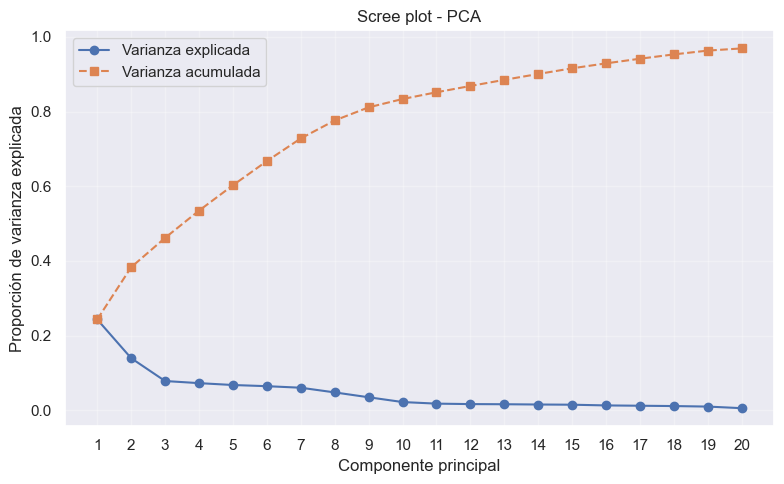

In [5]:
# 2.3 - Scree plot: varianza explicada y acumulada

print("=== SCREE PLOT PCA ===")

components = pca_summary["Componente"]
explained = pca_summary["Varianza_Explicada"]
cum_explained = pca_summary["Varianza_Explicada_Acumulada"]

plt.figure(figsize=(8, 5))

# Varianza explicada por componente
plt.plot(components, explained, marker="o", label="Varianza explicada")

# Varianza explicada acumulada
plt.plot(components, cum_explained, marker="s", linestyle="--", label="Varianza acumulada")

plt.xticks(components)
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza explicada")
plt.title("Scree plot - PCA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


=== PROYECCIÓN PCA 2D (PC1 vs PC2) ===


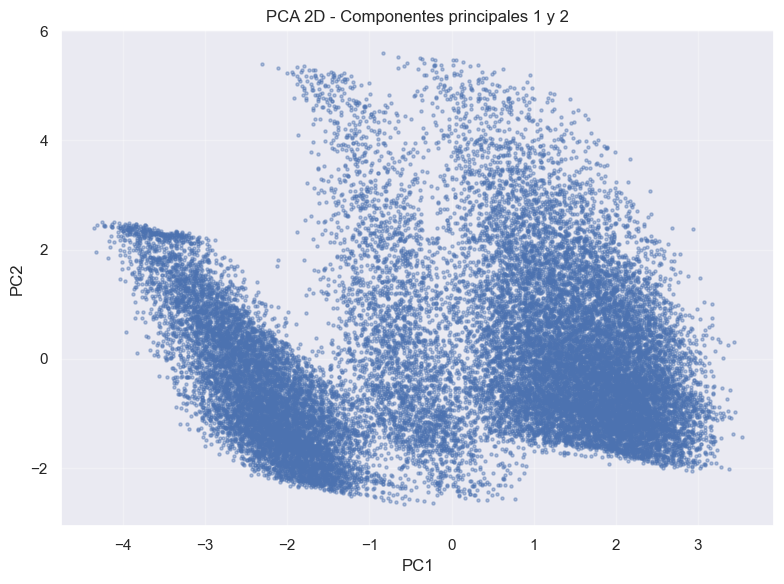

In [6]:
# 2.4 - Proyección PCA 2D (PC1 vs PC2)

print("=== PROYECCIÓN PCA 2D (PC1 vs PC2) ===")

pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, s=5, alpha=0.4)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D - Componentes principales 1 y 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# Guardar PC1 y PC2 en un DataFrame
pca_2d_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1]
})

pca_2d_df.head()


,PC1,PC2
0,-2.530484,-0.484448
1,-2.959780,1.555466
2,-2.957791,1.770201
3,-2.687015,-0.477361
4,-3.864895,2.402488


In [8]:
# 3.1 - UMAP 2D

print("=== UMAP 2D ===")

try:
    from umap import UMAP
except ImportError:
    raise ImportError(
        "UMAP no está instalado en este entorno. "
        "Ejecuta primero en una celda:  !pip install umap-learn"
    )

# Definir el modelo UMAP
umap_2d = UMAP(
    n_components=2,
    n_neighbors=15,   # tamaño de vecindario (puedes jugar luego con 15, 30, etc.)
    min_dist=0.1,     # qué tan “apretados” quedan los puntos
    random_state=42
)

# Ajustar y transformar
X_umap_2d = umap_2d.fit_transform(X)

# Guardar en DataFrame
umap_2d_df = pd.DataFrame({
    "UMAP1": X_umap_2d[:, 0],
    "UMAP2": X_umap_2d[:, 1]
})

print("Shape de embedding UMAP:", umap_2d_df.shape)
umap_2d_df.head()


=== UMAP 2D ===


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape de embedding UMAP: (26559, 2)


,UMAP1,UMAP2
0,12.732705,2.369354
1,-0.335836,-5.849336
2,13.015741,4.789526
3,0.457837,-3.360731
4,13.428514,4.754014


=== VISUALIZACIÓN UMAP 2D ===


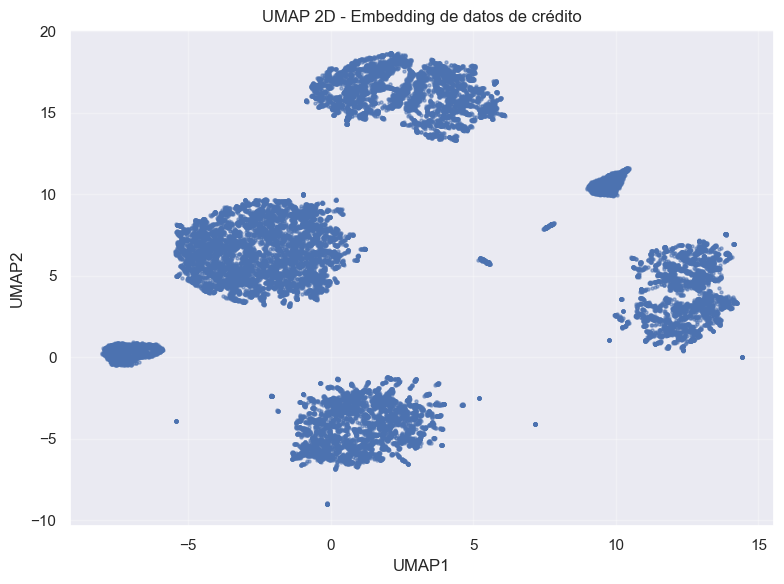

In [9]:
# 3.2 - Visualización UMAP 2D

print("=== VISUALIZACIÓN UMAP 2D ===")

plt.figure(figsize=(8, 6))
plt.scatter(umap_2d_df["UMAP1"], umap_2d_df["UMAP2"], s=5, alpha=0.5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP 2D - Embedding de datos de crédito")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# Guardar embeddings para usar en el Notebook 3 (clustering)

pca_2d_df.to_csv("embedding_pca_2d.csv", index=False)
umap_2d_df.to_csv("embedding_umap_2d.csv", index=False)

print("✓ Embeddings guardados en:")
print("  - embedding_pca_2d.csv")
print("  - embedding_umap_2d.csv")


✓ Embeddings guardados en:
  - embedding_pca_2d.csv
  - embedding_umap_2d.csv
